In [2]:
%load_ext autoreload
%autoreload 2

In [73]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product, count
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import *

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from montecarlo import *

This notebook caluclates the spectrum and IPRs as a function of temperature

In [74]:
#%%time
from time import time
from montecarlo import *
from general import index_histogram

class Eigenspectrum_IPR(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)

    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix, **kwargs):
        IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)
        self.eigenval_histogram[j], _, indices = index_histogram(self.eigenval_bins, evals)
        self.IPR_histogram[j] = np.bincount(indices, weights=IPRs, minlength = self.eigenval_bins.shape[0] + 1)[1:-1]

    
    def return_vals(self):
        E_histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(E_histogram)
        
        E_histogram = E_histogram / normalisation_factor 
        dE_histogram = scipy.stats.sem(self.eigenval_histogram, axis = 0) / normalisation_factor
        
        IPR_histogram, dIPR_histogram = np.mean(self.IPR_histogram, axis = 0), scipy.stats.sem(self.IPR_histogram, axis = 0)
        
        return self.eigenval_bins, E_histogram, dE_histogram, IPR_histogram, dIPR_histogram

In [75]:
from time import time
t0 = time()
Ns = [8,16,32,64,128,256]
Ts = np.array([0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10])
parameters = dict(t = 1, alpha = 1.5, mu = 0, beta = None, J = 10, U = 10, normalise = True)
n_bins = 1000
MCMC_params = dict(
        N_steps = int(10 * 1000),
        N_burn_in = int(1 * 1000), 
        logger = Eigenspectrum_IPR(bins = n_bins, limit = 10),
        proposal = p_multi_site_poisson_reflect,
        proposal_args = dict(lam = 1),
        accept_function = perturbation_accept,
        warnings = True,
    )

def compute(N, **kwargs):
    t0 = time()
    kwargs['state'] = np.arange(N) % 2
    bins, E, dE, IPR, dIPR = FK_mcmc_2(**kwargs)
    print(f'N = {N} in t = {time() - t0:.0f} seconds')
    return bins[:-1], E, dE, IPR, dIPR

In [ ]:
data = np.zeros(shape = (len(Ts), len(Ns), 5, n_bins))

for i, beta in zip(count(), 1/Ts):
    with multiprocessing.Pool(8) as pool:
        t2 = time()
        parameters['beta'] = beta
        curried = functools.partial(compute, parameters = parameters, **MCMC_params)
        data[i] = np.array(pool.map(curried, Ns))
        print(f'T = {1/beta} done in {(time() - t2)/60 :.0f} minutes')


np.savez('./pickled_data/beta_IPRs_3.npz', 
        Ts = Ts, Ns=Ns, parameters = parameters, MCMC_params=MCMC_params, data=data, allow_pickle = True, time = time() - t0,
        desc = '''
        IPRS and Eigenstpectrum as a function of temp and system size
        data.shape = (betas, Ns, 5, n_bins)
        '''
        )
print(f'done in {(time() - t0) / 60**2:.0f} hours')

N = 8 in t = 24 seconds
N = 16 in t = 42 seconds
N = 32 in t = 86 seconds
N = 64 in t = 351 seconds
N = 128 in t = 1030 seconds


In [47]:
from general import smooth
from itertools import count

def print_keys(d):
    for k,v in d.items():
        if k == 'data':  print(f'{k} with shape = {v.shape}')
        else:  print(f'{k} = {v}')

def plot_DOS_and_IPR(IPR_ax, DOS_ax, data, label, scale = 0.1):
    bins, E, dE, IPR, dIPR = data
    IPR = IPR / N
    DOS_ax.plot(bins, smooth(E, scale), label = label)
    IPR_ax.plot(bins,  smooth(np.where(E > 0, IPR / E, 0), scale), label = label)

filename = './pickled_data/beta_IPRs_2.npz'    
p = np.load(filename, allow_pickle = True)
print_keys(p)

Ts = [ 0.1  0.5  1.   1.5  2.   2.5  3.   5.  10. ]
Ns = [  8  16  32  64 128]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.1, 'J': 10, 'U': 10, 'normalise': True}
MCMC_params = {'N_steps': 10000, 'N_burn_in': 1000, 'logger': <__main__.Eigenspectrum_IPR object at 0x7fc8bdbaf6a0>, 'proposal': <function p_multi_site_poisson_reflect at 0x7fc8cc434840>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7fc8cc434ae8>, 'warnings': True}
data with shape = (9, 5, 5, 1000)
time = 8356.365334033966
desc = 
        IPRS and Eigenstpectrum as a function of temp and system size
        data.shape = (betas, Ns, 5, n_bins)
        


In [ ]:
f, axes = plt.subplots(len(p['Ts']),2, figsize  = (7.2 * 1.6,7.2), sharex = 'all')

for (DOS_ax, IPR_ax), T, betaslice in zip(axes, p['Ts'], p['data']):
    for i, col, N, Nslice in zip(count(), colors, p['Ns'], betaslice):
        plot_DOS_and_IPR(IPR_ax, DOS_ax, data = Nslice, label = f'N = {N}', scale = 0.1)
        DOS_ax.set(ylabel = f'T = {T}\n DOS')
        IPR_ax.set(ylabel = f'IPR')
    
axes[-1, 0].legend()    

/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


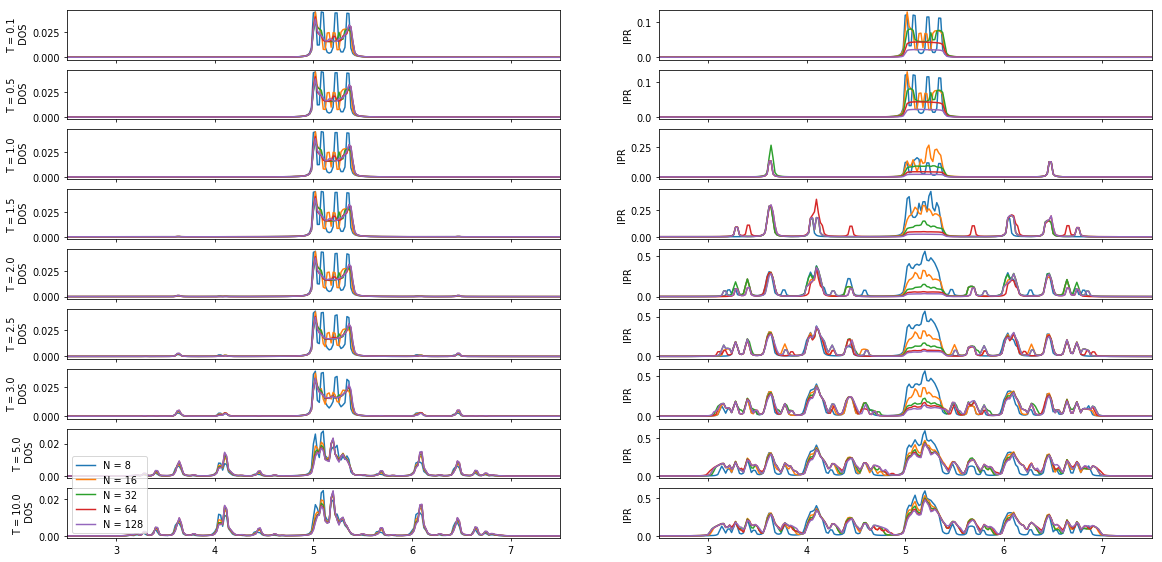

In [77]:
f, axes = plt.subplots(len(p['Ts']),2, figsize  = (20,10), sharex = 'all')

for (DOS_ax, IPR_ax), T, betaslice in zip(axes, p['Ts'], p['data']):
    for i, col, N, Nslice in zip(count(), colors, p['Ns'], betaslice):
        plot_DOS_and_IPR(IPR_ax, DOS_ax, data = Nslice, label = f'N = {N}', scale = 0.1)
        DOS_ax.set(ylabel = f'T = {T}\n DOS')
        IPR_ax.set(ylabel = f'IPR', xlim= (2.5, 7.5))
    
axes[-1, 0].legend()    
f.savefig('./figs/IPR_vs_beta.pdf')
        